# EPA IDS Data
We use EPA’s IDS database to supplement formal ECHO violation records by capturing self-reported pesticide-related incidents. By using topic modeling and textual analysis, we filtered agriculture-related exposure cases and aggregated them by state and year. This enables us to build a proxy for potential underregulation and compare it against official enforcement outcomes across SLAs.
## Data Overview 

This dataset includes self-reported pesticide-related incidents from 2014-2024. It captures the type of incident (Human-related is the one I focused on but theres ~5 different types), the state it occured  in, and the county if available. This data offers an alternative to the echo data in how incidents within the agriculture space   are treated. 

## Data Collection
Data was obtained from scraping from the [EPA IDS website](https://ordspub.epa.gov/ords/pesticides/f?p=359:1).
Queries were left blank to allow for every possible incident to be analyzed 

## Data Structure 
Incident Data (DateTime Object): When the incident was reported 
Reason for Report (String): 2 word summary of incident  
Impact of Incident (String): Denotes the incident to a 2-letter code, ie HC for Human Moderate 
Country (String): Country of Occurrence  
State (String): State of Occurrence 
County (String): County of  Occurrence 
City(String): City of Occurrence 
Product Reg # (String): If a pesticide was involved or reported what is the # code 
Product Name (String): If a pesticide was involved what is the product 
PC Code (Int): An EPA designated code for each pesticide 
Active Ingredients (String): The actice ingredient in the pesticide 
Clean (String): A cleaned version of what happened with the incident  

In [1]:
import pandas as pd

# Load raw data
df = pd.read_csv("IDS.csv")

# show data size and the first 5 raws
print("dataset size: ", len(df))
df.head()


dataset size:  18609


,Incident Number,Incident Date,Reason for Report,Impact of Incident,Country,State,County,City,Product Registration Number(s),Product Names,PC Codes,Active Ingredient(s),Overall Submission Description (may describe multiple incidents)
0,026567-00010,02/26/2014,Adverse Reaction,ON - Other Nontarget,US,CA,Merced,NaN,NaN,NaN,035001,Dimethoate,"US EPA Region 9: 21 reports including updates,..."
1,026567-00018,05/08/2014,Adverse Reaction,ON - Other Nontarget,US,CA,Tulare,NaN,NaN,NaN,NaN,Unknown Ingredients,"US EPA Region 9: 21 reports including updates,..."
2,026800-00005,05/14/2014,Adverse Reaction,ON - Other Nontarget,CN,NaN,Ontario,Grey,NaN,NaN,044309,Clothianidin,"8 Canadian bee kill incidents, Ontario, 2012, ..."
3,026800-00005,05/14/2014,Adverse Reaction,ON - Other Nontarget,CN,NaN,Ontario,Grey,NaN,NaN,109302,Fluvalinate,"8 Canadian bee kill incidents, Ontario, 2012, ..."
4,026800-00005,05/14/2014,Adverse Reaction,ON - Other Nontarget,CN,NaN,Ontario,Grey,NaN,NaN,099050,Acetamiprid,"8 Canadian bee kill incidents, Ontario, 2012, ..."


## Data Processing 
To ensure the dataset was suitable for topic modeling and downstream analysis, we performed the following data cleaning steps:
### Column Normalization and Geographic Filtering
1. All column names and string fields were stripped of leading/trailing whitespace for consistency.
2. Country codes were converted to uppercase.
3. Only records with human-related impacts (identified via the "Impact of Incident" field containing an "H") were retained.
4. We further filtered for U.S.-based incidents by keeping rows where "Country" == "US".

### Text Standardization for NLP
A multi-step preprocessing pipeline was applied to the free-text description field to enhance the quality of the topic modeling:

1. Year and number removal: All standalone numeric tokens and 4-digit years (1980–2029) were stripped from the text to avoid skewing topic generation with dates or IDs.
2. Noise word filtering: A custom list of domain-specific noise terms was compiled, including:
    Brand names (e.g., Monsanto, Bayer, Syngenta)
    Month and date markers (e.g., "August", "week")
    Non-descriptive fillers (e.g., "report", "update", "approximately", "entered", etc.)
3. Tokenization and Lemmatization: Text was tokenized using the Treebank tokenizer, then lemmatized using WordNet to reduce words to their base verb forms (e.g., "sprayed" → "spray").

### Cleaned Text Output
The result of the preprocessing pipeline was stored in a new column called "Clean", which was used as input for vectorization and topic modeling.

In [2]:
# remove column names and empty space
df.columns = df.columns.str.strip()
df["Country"] = df["Country"].str.strip().str.upper()

# filter for human-related incidents
df_human = df[df["Impact of Incident"].str.contains("H", na=False)]

# filter for U.S.-based incidents
df_human = df_human[df_human["Country"].str.upper() == "US"]

# Filtered dataset size
print("Filtered dataset size: ", len(df_human))
df_human.head()

Filtered dataset size:  13011


,Incident Number,Incident Date,Reason for Report,Impact of Incident,Country,State,County,City,Product Registration Number(s),Product Names,PC Codes,Active Ingredient(s),Overall Submission Description (may describe multiple incidents)
5,027212-00004,11/07/2014,Adverse Reaction,"HB - Human - Major, HC - Human - Moderate",US,MS,NaN,NaN,000100-00990,Demon Wp Insecticide,109702,Cypermethrin,"Syngenta: 1 H-B and 4 H-C individual reports, ..."
6,027220-00001,11/06/2014,Product Defect,HC - Human - Moderate,US,VA,Augusta,Weyers Cave,072959-00006,Degesch Fumi Cel,066504,Magnesium phosphide,Degesch America: 1 H-C: trauma & severe bruisi...
7,027251-00001,11/17/2014,Adverse Reaction,HA - Human Fatality,US,CO,NaN,Briscoe,005185-00505-080306,The Works Toilet Bowl Cleaner,045901,Hydrochloric acid,Biolab: 1 H-A: male's suicidal death involving...
8,027251-00001,11/17/2014,Adverse Reaction,HA - Human Fatality,US,CO,NaN,Briscoe,NaN,Hi Yield Lime Sulfur Spray,076702,Lime sulfur,Biolab: 1 H-A: male's suicidal death involving...
9,027261-00001,11/23/2014,Adverse Reaction,"HC - Human - Moderate, HD - Human - Minor",US,KY,NaN,Science Hill,NaN,Total Pest Control,109701,Permethrin,NPIC: woman and her daughter experienced sympt...


In [3]:
import re

# function to remove years and standalone numbers from text
def remove_years(text):
    '''
    Removes all 4-digit year patterns (from 1980 to 2029) 
    and any standalone numeric tokens from the input text.

    Parameters:
        text (str): The original text string.

    Returns:
        str: Cleaned text with years and numbers removed.
    '''
    # Remove 4-digit years from 1980–2029
    text = re.sub(r'\b(20[0-2][0-9]|19[8-9][0-9])\b', '', text)
    # Remove all numbers (standalone or attached)
    text = re.sub(r'\b\d+\b', '', text)
    return text

In [4]:
# Define lists of month names, brand names, and other common noise words
MONTHS = [
    "jan", "january", "feb", "february", "mar", "march", "apr", "april",
    "may", "jun", "june", "jul", "july", "aug", "august", "sep", "sept", "september",
    "oct", "october", "nov", "november", "dec", "december", "week"]
BRANDS = ["monsanto", "basf", "bayer", "jk", "sc", "johnson", "benckiser", "reckitt", "otts", "lonza", "pb", "engenia",
         "mgk"]
COMMON_NOISE = ["report", "reports", "update", "summaries", "entered", "annual", "aggregate", "approximately", "il", "region", "products", "scotts", "unite"]

# Function to remove predefined noise words (brands, months, etc.) from text
def remove_noise_words(text):
    '''
    Removes brand names, months, and other common non-informative terms 
    from the input text to reduce noise for topic modeling.

    Parameters:
        text (str): The original lowercase input string.

    Returns:
        str: Text with noise words removed and extra whitespace stripped.
    '''
    text = text.lower()
    for word in BRANDS + COMMON_NOISE + MONTHS:
        text = re.sub(rf'\b{re.escape(word)}\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

# Initialize the tokenizer and lemmatizer
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

# Tokenize and lemmatize the input text to its base (verb) form
def lemmatize_text(text):
    '''
    Tokenizes and lemmatizes the input text using Treebank tokenizer and WordNet lemmatizer.
    Each word is reduced to its base verb form to improve text normalization 
    for topic modeling or other NLP tasks.

    Parameters:
        text (str): The input string to process.

    Returns:
        str: A single string of space-separated lemmatized words.
    '''
    words = tokenizer.tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

In [6]:
# Full text preprocessing function used before LDA topic modeling
def clean_for_lda(text):
    '''
    Cleans the input text by applying the following steps:
    - Converts to lowercase
    - Removes years and standalone numbers
    - Removes predefined noise words (months, brands, filler words)
    - Lemmatizes words to their base verb form
    - Removes all punctuation

    This function prepares the text for topic modeling (e.g., LDA).

    Parameters:
        text (str): The raw input string.

    Returns:
        str: A fully cleaned and lemmatized string.
    '''
    text = str(text).lower()
    text = remove_years(text)
    text = remove_noise_words(text)
    text = lemmatize_text(text)
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text

In [7]:
# Use 'clean' if available, else use fallback field
text_col = "Clean" if "Clean" in df.columns else "Overall Submission Description (may describe multiple incidents)"

# Fill missing values with empty strings
texts_cleaned = df_human[text_col].fillna("").apply(clean_for_lda)
df_human['Clean'] = texts_cleaned  # store result back into df_human

# Filtered dataset size
df_human.head()

,Incident Number,Incident Date,Reason for Report,Impact of Incident,Country,State,County,City,Product Registration Number(s),Product Names,PC Codes,Active Ingredient(s),Overall Submission Description (may describe multiple incidents),Clean
5,027212-00004,11/07/2014,Adverse Reaction,"HB - Human - Major, HC - Human - Moderate",US,MS,NaN,NaN,000100-00990,Demon Wp Insecticide,109702,Cypermethrin,"Syngenta: 1 H-B and 4 H-C individual reports, ...",syngenta hb and hc individual
6,027220-00001,11/06/2014,Product Defect,HC - Human - Moderate,US,VA,Augusta,Weyers Cave,072959-00006,Degesch Fumi Cel,066504,Magnesium phosphide,Degesch America: 1 H-C: trauma & severe bruisi...,degesch america hc trauma severe bruise to ...
7,027251-00001,11/17/2014,Adverse Reaction,HA - Human Fatality,US,CO,NaN,Briscoe,005185-00505-080306,The Works Toilet Bowl Cleaner,045901,Hydrochloric acid,Biolab: 1 H-A: male's suicidal death involving...,biolab ha male s suicidal death involve the ...
8,027251-00001,11/17/2014,Adverse Reaction,HA - Human Fatality,US,CO,NaN,Briscoe,NaN,Hi Yield Lime Sulfur Spray,076702,Lime sulfur,Biolab: 1 H-A: male's suicidal death involving...,biolab ha male s suicidal death involve the ...
9,027261-00001,11/23/2014,Adverse Reaction,"HC - Human - Moderate, HD - Human - Minor",US,KY,NaN,Science Hill,NaN,Total Pest Control,109701,Permethrin,NPIC: woman and her daughter experienced sympt...,npic woman and her daughter experience sympto...


## Topic Modeling: LDA Overview
Latent Dirichlet Allocation (LDA) is an unsupervised machine learning algorithm used to discover latent themes (topics) in large text corpora. In this project, we used LDA to extract dominant patterns from the narrative descriptions of pesticide-related incidents reported in EPA’s IDS dataset.

### Modeling Details:
    Input Text: Cleaned free-text from the Overall Submission Description field
    Vectorizer: CountVectorizer (bag-of-words), with:
        stop_words='english': removes common English filler words
        max_df=0.95: removes words that appear in more than 95% of documents
        min_df=10: removes words that appear in fewer than 10 documents

### LDA Parameters:
    n_components=5: model extracts 5 distinct topics from the data
    random_state=42: ensures reproducibility

### Interpretation:
Each topic is represented by the top 10 most significant words. These words are not assigned meaning by the algorithm — interpretation is manual. We reviewed each topic and classified it as relevant or irrelevant to agricultural pesticide exposure, based on the presence of:
Terms related to farm labor or application practices (e.g., field, workers, pesticide, application)
Symptoms or health outcomes plausibly related to agricultural exposure
Exclusion of topics dominated by brands, products, dates, or generic metadata

### Outcome:
We selected topics 0, 2, and 3 as relevant to our research goal and used them to filter agricultural exposure cases for further analysis.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert text into vectorized form (bag of words)
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=10)
X = vectorizer.fit_transform(df_human['Clean'])

# Fit and LDA model with 5 topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Print top words in each topic
def print_topics(model, vectorizer, top_n=10):
    '''
    Prints the top N keywords for each topic extracted from an LDA model.

    Parameters:
        model (LatentDirichletAllocation): The trained LDA model.
        vectorizer (CountVectorizer): The vectorizer used to convert text to word matrix.
        top_n (int): Number of top words to display per topic. Default is 10.

    Returns:
        None (prints output directly)
    '''
    for idx, topic in enumerate(model.components_):
        top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-top_n:]]
        print(f"Topic {idx}: {top_words}")

print_topics(lda, vectorizer)

Topic 0: ['burn', 'ocular', 'rash', 'pa', 'pain', 'hb', 'irritation', 'hc', 'symptoms', 'include']
Topic 1: ['health', 'animal', 'syngenta', 'ea', 'industries', 'unite', 'symptoms', 'hb', 'include', 'hc']
Topic 2: ['pet', 'pa', 'roundup', 'glyphosate', 'human', 'hb', 'hc', 'individual', 'incidents', 'incident']
Topic 3: ['orchard', 'agricultural', 'pesticide', 'experience', 'cac', 'symptoms', 'workers', 'county', 'field', 'application']
Topic 4: ['incident', 'report', 'expose', 'hospital', 'yearold', 'npic', 'male', 'symptoms', 'pesticide', 'experience']


## Topic Analysis
### Topic 0 (Keep)
['burn', 'ocular', 'rash', 'pa', 'pain', 'hb', 'irritation', 'hc', 'symptoms', 'include']

#### Analysis:
Focused on physical symptoms and mild-to-moderate health effects
Contains "ocular", "burn", "rash", "irritation" — all clear human symptoms
Includes "hb", "hc" = health severity codes → remove from topic modeling, but important for labeling

#### Interpretation:
Human Symptom Reports (likely low/moderate severity)

### Topic 1 (Drop)
['health', 'animal', 'syngenta', 'ea', 'industries', 'unite', 'symptoms', 'hb', 'include', 'hc']

#### Analysis:
Mixed content: "animal", "industries", "unite" don’t form a strong agricultural theme
"syngenta" is a brand → noise
"ea" unclear, likely noise
"symptoms" and "health" are general-purpose

#### Interpretation:
Mixed or off-topic, maybe non-agriculture product-related or brand-related incidents

### Topic 2 (Keep):
['pet', 'pa', 'roundup', 'glyphosate', 'human', 'hb', 'hc', 'individual', 'incidents', 'incident']

#### Analysis:
"pet", "roundup", "glyphosate" = household or home-and-garden products
"human" is vague; "pa" is a state code → noise
"hb"/"hc" still present

#### Interpretation:
Household/Pet-related pesticide exposure, not always agriculture
We could extract only relevant records.

### Topic 3 (Keep):
['orchard', 'agricultural', 'pesticide', 'experience', 'cac', 'symptoms', 'workers', 'county', 'field', 'application']

#### Analysis:
This is your best and clearest topic.
Strong keywords: "orchard", "agricultural", "pesticide", "application", "field", "workers"

#### Interpretation:
Agricultural exposure — your main interest

### Topic 4 (Drop):
['incident', 'report', 'expose', 'hospital', 'yearold', 'npic', 'male', 'symptoms', 'pesticide', 'experience']

#### Analysis:
This topic feels generic
"hospital", "yearold", "male" — repeated structure of incident reports
"npic" and "report" → possible system-level noise

#### Interpretation:
Metadata or general incident structure, not conceptually useful on its own

In [9]:
# Get topic distribution per incident
topic_distribution = lda.transform(X)

# Assign the most probable topic to each record
df_human['Topic'] = topic_distribution.argmax(axis=1)

# Show how many records per topic
df_human['Topic'].value_counts()

Topic
0    5408
1    2615
2    2432
4    1497
3    1059
Name: count, dtype: int64

In [10]:
# Keep Topic 0, 2, 3
df_relevant = df_human[df_human['Topic'].isin([0, 2, 3])].copy()

# Filter agriculture exposure
AG_EXPOSURE_KEYWORDS = [
    "pesticide", "application", "spray", "expose", "exposure", "mix", "handle",
    "farm", "field", "crop", "greenhouse", "orchard", "tractor", "vineyard",
    "worker", "farmworker", "applicator", "labor", "symptoms", "irritation",
    "rash", "nausea", "vomiting", "residue", "treated", "chemical", "drift"
]

# Apply new keyword filter
def is_agriculture_related(text):
    '''
    Checks whether a given text contains any agriculture-related exposure keywords.

    Parameters:
        text (str): The input string (usually from the 'Clean' column).

    Returns:
        bool: True if any agricultural keyword is found, False otherwise.
    '''
    text = str(text).lower()
    return any(word in text for word in AG_EXPOSURE_KEYWORDS)

df_filtered = df_relevant[df_relevant['Clean'].apply(is_agriculture_related)].copy()
print(f"Filtered incidents with relevant topics + ag exposure keywords: {len(df_filtered)}")

Filtered incidents with relevant topics + ag exposure keywords: 6002


In [11]:
# extract year from 'incident Date'
df_filtered['year'] = pd.to_datetime(df_filtered['Incident Date'], errors='coerce').dt.year

# Group by state and year
df_ids_summary = df_filtered.groupby(['State', 'year']).size().reset_index(name='ids_event_count')

In [12]:
# save the outputs
df_filtered.to_csv("IDS_agriculture.csv", index=False)
df_ids_summary.to_csv("IDS_state_year_count.csv", index=False)
print("Saved filtered incidents and state-year counts.")

# grouped dataset
print("grouped dataset size: ", len(df_ids_summary))
df_ids_summary.head()

Saved filtered incidents and state-year counts.
grouped dataset size:  473


,State,year,ids_event_count
0,AK,2016,2
1,AK,2017,1
2,AK,2019,2
3,AK,2021,1
4,AK,2022,1


## Visualization
### Heatmap of Agricultural Incident Reports by State and Year
This heatmap visualizes the geographic and temporal distribution of self-reported agricultural pesticide exposure incidents across U.S. states from 2014 to 2024. Each row corresponds to a state and each column to a year. The color intensity represents the number of reported incidents.

    - California (CA) stands out as a persistent hotspot, especially between 2017 and 2020, suggesting a high frequency of reported exposures.
    - Other states such as Texas (TX) and Florida (FL) show moderate levels of incidents.
    - Many states show low or sparse reporting, potentially indicating underreporting or low agricultural activity.

This chart helps identify spatial disparities in incident reporting, which can later be compared with enforcement outcomes to assess regulatory consistency.

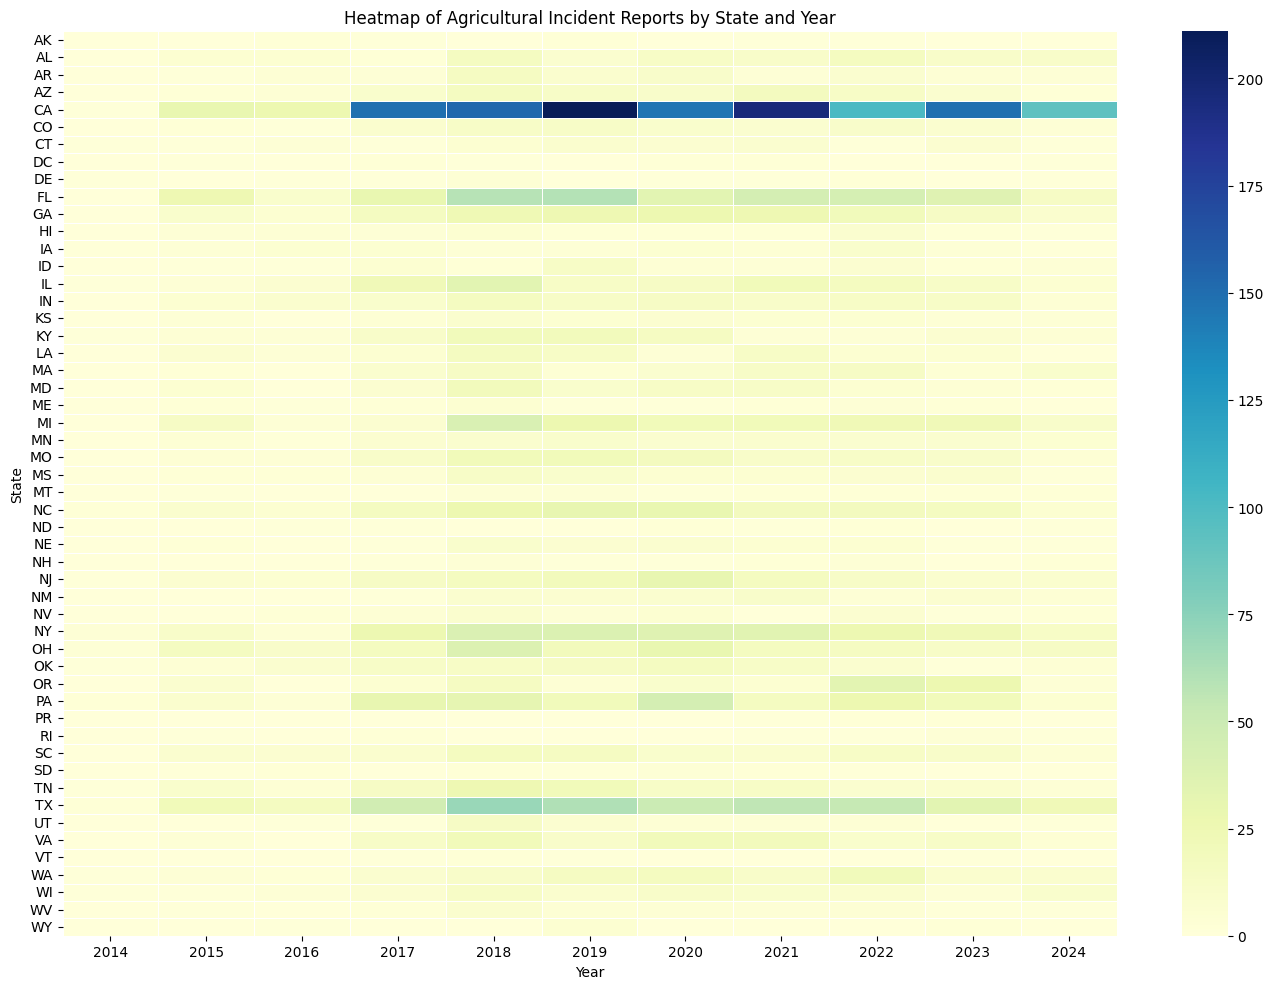

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# read state_year_count data file
df_summary = pd.read_csv("IDS_state_year_count.csv")

# Pivot the data to create a heatmap-friendly format
pivot_table = df_summary.pivot(index="State", columns="year", values="ids_event_count").fillna(0)

# Draw the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap of Agricultural Incident Reports by State and Year")
plt.xlabel("Year")
plt.ylabel("State")
plt.tight_layout()
plt.show()

### Trend of Agricultural-Related Incidents Over Time
This line chart presents the total number of filtered agricultural-related incidents reported each year from 2014 to 2024.

    - The number of incidents increased sharply from 2016 to a peak in 2018, suggesting either a spike in exposure events or improved reporting.

    - After 2018, there is a gradual decline, with the lowest count in 2024, possibly due to policy changes, underreporting, or pandemic-related disruptions.

This trend analysis helps evaluate temporal changes in agricultural exposure events and supports further questions like:
"Are regulatory responses or inspections aligned with the rise and fall of these exposures?"

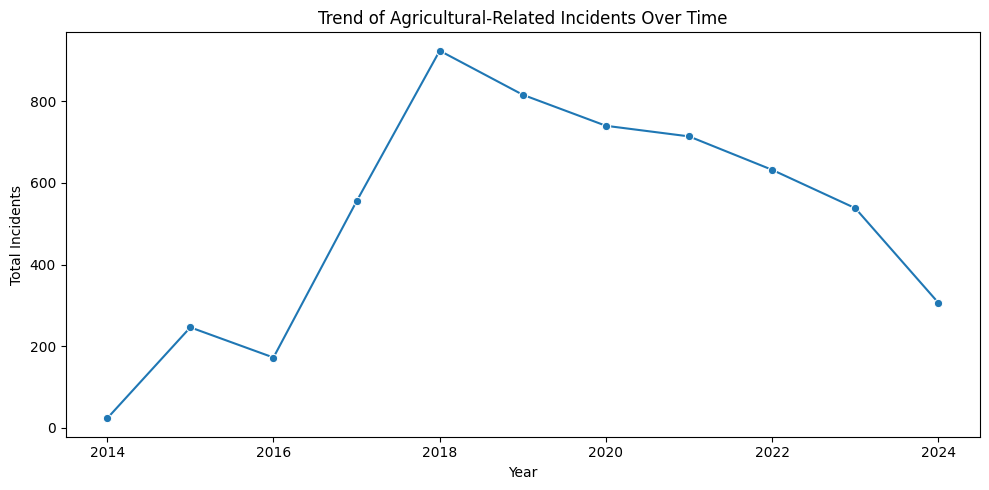

In [14]:
# Group data by year to calculate total number of incidents
yearly_trend = df_summary.groupby("year")["ids_event_count"].sum().reset_index()

# Plot line chart
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_trend, x="year", y="ids_event_count", marker="o")
plt.title("Trend of Agricultural-Related Incidents Over Time")
plt.xlabel("Year")
plt.ylabel("Total Incidents")
plt.tight_layout()
plt.show()

## Data Quality & Limitations 

- Self-Reported Nature: The biggest issue with the data is the fact that it is self-reported. This means that a lot of the incident descriptions are not very well detailed and it also leaves to the possibility that many incidents are not reported.

- Non-Standardized Descriptions: The incident descriptions are written in free-text form, requiring extensive cleaning and normalization. This can lead to loss of subtle semantic meaning and introduces subjectivity in keyword filtering or topic modeling.